# Subhalo Mass Function and Half-mode Mass

In this notebook we look at the implications of falsely counting interlopers as subhalos when estimating
the subhalo mass function.

We also calculate the posteriors on the half-mode mass using future interloper detections.

In [1]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors
import scipy
from scipy import stats
import numpy as np
from astropy import constants as const
from scipy.stats import poisson
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from scipy import interpolate
from scipy.special import factorial

# A function that calculates the critical surface mass density
def sigma_cr(zlens,zsource):
    #mass in Msun
    dl = cosmo.angular_diameter_distance_z1z2(0.,zlens)
    ds = cosmo.angular_diameter_distance_z1z2(0.,zsource)
    dls = cosmo.angular_diameter_distance_z1z2(zlens,zsource)
    
    G = const.G
    c = const.c
    
    return (ds/(dls*dl))*((c**2.)/(4.*np.pi*G))


# A function that gives the subhalo mass function by taking f_sub, beta, and mass range as input
def dndmsub(fsub,beta,z_lens,z_source,mhigh0,mlow0):
    def massfunc(M0):
        M = M0*u.Msun
        mhigh = mhigh0*u.Msun
        mlow = mlow0*u.Msun
        
        sigcr = sigma_cr(0.5,z_source)
        
        return fsub*float((M**beta)*sigcr*0.3*((2.+beta)/(mhigh**(2.+beta) - mlow**(2.+beta)))*(((1.+z_lens)/(1+0.5))**(2.5))*(u.Msun)*(u.Mpc**2))
    
    return massfunc #in units of N/Mpc2


def cmdz(z):
    ## takes in redshift, returns comoving distance in Mpc
    return cosmo.comoving_distance(z)

def cmd(a):
    ## takes in scale factor, returns comoving distance in Mpc
    z = (1./a)-1.
    return cmdz(z)

avls = np.logspace(0.0001,-2.,10000)
cmds = cmd(avls)


a_scale = interpolate.interp1d(cmds, avls)


### here we define the multipliers
def add(chi1,chi2):
    a2 = a_scale(chi2)
    return a2*(chi2 - chi1)

def beta(chi1,chi2,chis):
    return (add(chi1,chi2)*add(0.,chis))/(add(0.,chi2)*add(chi1,chis))


def f_func(chi,chil,chis):
    if chi<=chil:
        return 1. - beta(chi,chil,chis)
    if chi>chil:
        return 1. - beta(chil,chi,chis)
    
def g_func(chi,chil,chis):
    if chi<=chil:
        return 1.
    if chi>chil:
        return 1. - beta(chil,chi,chis)

#Loading up sheth-tormen halo mass function.
massesn = np.load('../WIDE_massesn_STnew.npy')
massfunc0ST = np.load('../WIDE_massfunc_STnew.npy')
zs = np.load('../WIDE_redshifts_STnew.npy')

msfnc = interpolate.interp2d(zs,massesn,massfunc0ST)

def halo_mf_hm(HMmass):
    # enter HM mass in msun
    # returns halo mass function
    def mssfn(z,M):
        return msfnc(z,M)*((1.+(HMmass/M))**-1.3)
    
    return mssfn

def mu_in_binz(mlow,mhigh,massfunc,area,zint,dz):
    #given a mass function and bin range and area
    #calculates the expected number of halos
    
    def msfn(M):
        return massfunc(zint,M)
    
    chi1 = cmdz(zint)/u.Mpc
    chi2 = cmdz(zint+dz)/u.Mpc
    
    volume = area*(chi2-chi1)
    
    #enter volume in Mpc3
    #change this to 
    integ = scipy.integrate.quad(msfn,mlow,mhigh)
    
    return float(volume*integ[0]),float(volume*integ[1])


def mu_in_binsub(mlow,mhigh,massfunc,area):
    #given a mass function and bin range and volume
    #calculates the expected number of halos
    
    
    #enter volume in Mpc3
    #change this to 
    integ = scipy.integrate.quad(massfunc,mlow,mhigh)
    
    return area*integ[0],area*integ[1]


print(mu_in_binz(1.0e8,1.1e8,msfnc,0.0003584900280551569,0.881,0.2))

(0.19218017345832478, 2.565676477675563e-09)


In [2]:
def area_ratio(chi,chil,chis):
    #The ratio of the cross section area of the double cone
    #at cmd chi to cmd chil.
    return ((g_func(chi,chil,chis)/a_scale(chil))*(chi/chil))**2.

def meff2(zi,zl,zs):
    #Effective mass of the interlopers to put them
    #in the correct effective subhalo mass bin
    scr_l = sigma_cr(zl,zs)
    scr_i = sigma_cr(zi,zs)
    return float(scr_l/scr_i)

In [3]:
chilval = cmdz(0.881)
chisval = cmdz(2.057)
chivals = np.linspace(0.,chisval,200)

arearats = [area_ratio(chivals[i],chilval,chisval) for i in range(200)]

In [4]:
def expected_detections(zbinvals,mbinvals,massfunc,area,zl,zs):
    ## the expected number of interloper detections in a given 
    ## effective area for a given lens and source redshift zl,zs
    ## area is the physical area on the lens plane in mpc2
    mus = np.zeros([len(zbinvals)-1,len(mbinvals)-1])
    ers = np.zeros([len(zbinvals)-1,len(mbinvals)-1])
    for i in range(len(zbinvals)-1):
        z1 = zbinvals[i]
        z2 = zbinvals[i+1]
        
        chi = cmdz(z1)
        chil = cmdz(zl)
        chis = cmdz(zs)
        
        area_z = area_ratio(chi,chil,chis)*area
        
        for j in range(len(mbinvals)-1):
            mlow = mbinvals[j]/meff2(z1,zl,zs)
            mhigh = mbinvals[j+1]/meff2(z1,zl,zs)
            integval = mu_in_binz(mlow,mhigh,massfunc,area_z,z1,z2-z1)
            mus[i,j] = integval[0]
            ers[i,j] = integval[1]
            
            
    return mus,ers

def expected_detectionssub(binvals,massfunc,area):
    ## the expected number of subhalo detections in a given 
    ## effective area for a given lens and source redshift zl,zs
    ## area is the physical area on the lens plane in mpc2
    mus = np.zeros(len(binvals)-1)
    ers = np.zeros(len(binvals)-1)
    for i in range(len(binvals)-1):
        mlow = binvals[i]
        mhigh = binvals[i+1]
        
        integval = mu_in_binsub(mlow,mhigh,massfunc,area)
        mus[i] = integval[0]
        ers[i] = integval[1]
    return mus,ers


def generate_detections(zbinvals,mbinvals,massfunc,area,zl,zs):
    ## generates a poissonian realization of the expected
    ## number of interloper detections
    mus, ers = expected_detections(zbinvals,mbinvals,massfunc,area,zl,zs)
        
    dets = poisson.rvs(mus)
    return dets,mus,ers

def generate_detectionssub(binvals,massfunc,area):
    ## generates a poissonian realization of the expected
    ## number of subhalo detections
    mus, ers = expected_detectionssub(binvals,massfunc,area)
        
    dets = poisson.rvs(mus)
    return dets,mus,ers

In [5]:
fsub0 = 3e-2
beta0 = -1.9
zl0 = 0.881
zs0 = 2.059
mh = 1e11
ml = 1e8

msfnc2 = dndmsub(fsub0,beta0,zl0,zs0,mh,ml)


zlval = zl0
zsval = zs0
areaval = 10*1.8279008208279057e-05
areabig = 90*1.8279008208279057e-05

zbinvals = np.linspace(0.00001,zsval-0.00001,31)
mbinvals = np.logspace(8.,11.,31)

In [6]:
def likelihood_sub(dets,binvals,area):
    ## returns ln likelihood as a function of fsub and beta
    ## for a given number of detections.
    def lnlike(fsub,beta):
        massfuncq = dndmsub(fsub,beta,zl0,zs0,mh,ml)

        
        mus,ers = expected_detectionssub(binvals,massfuncq,area)
        
        tally = 0.
        
        for i in range(len(dets)):
            if dets[i] ==0:
                adder = -mus[i]
            else:
                adder = -(mus[i]+np.log(((factorial(dets[i]))/(mus[i]**dets[i]))))
            tally += adder
            
        return tally
    return lnlike

def likelihood_sub2(dets,binvals,area,fsub,beta):
    massfuncq = dndmsub(fsub,beta,zl0,zs0,mh,ml)

        
    mus,ers = expected_detectionssub(binvals,massfuncq,area)
        
    tally = 0.
        
    for i in range(len(dets)):
        if dets[i] ==0:
            adder = -mus[i]
        else:
            adder = -(mus[i]-dets[i]+dets[i]*np.log(dets[i]/mus[i]))
        tally += adder
            
    return tally

In [7]:
Amin = 0.#fsub0/20
Amax = 0.6
amin = -3.501
amax =  -1.002

Nval = 150

Avals = np.linspace(Amin,Amax,Nval )
avals = np.linspace(amin,amax,Nval )

In [8]:
Dl = cosmo.angular_diameter_distance_z1z2(0.,zl0)
arcsec = 4.84814e-6

annulus = 0.1
radius = 0.4589

area_eff = float((2*np.pi*radius*annulus*(arcsec**2))*(Dl**2)/u.Mpc**2.)

In [9]:
zlval = zl0
zsval = zs0
areaval = 10*area_eff 
areavalb = 30*area_eff 
areavalbb = 90*area_eff 

zbinvals = np.linspace(0.00001,zsval-0.00001,20)
mbinvals = np.logspace(8.,11.,31)

half2 = 1e8
fnc2 = halo_mf_hm(half2)

dettest1sub, mutest1sub, ertest1sub = generate_detectionssub(mbinvals,msfnc2,areaval)
dettest1bsub, mutest1bsub, ertest1bsub = generate_detectionssub(mbinvals,msfnc2,areavalb)
dettest1bbsub, mutest1bbsub, ertest1bbsub = generate_detectionssub(mbinvals,msfnc2,areavalbb)

print(dettest1sub,np.sum(dettest1sub))
print(dettest1bsub,np.sum(dettest1bsub))
print(dettest1bbsub,np.sum(dettest1bbsub))

dettest1,mutest1,ertest1 = generate_detections(zbinvals,mbinvals,fnc2,areaval,zlval,zsval)
dettest1b,mutest1b,ertest1b = generate_detections(zbinvals,mbinvals,fnc2,areavalb,zlval,zsval)
dettest1bb,mutest1bb,ertest1bb = generate_detections(zbinvals,mbinvals,fnc2,areavalbb,zlval,zsval)

In [10]:
## We load a poissonian realization generated by the code above.
det1 = np.load('stats/dettest_10jvals_area.npy')
det2 = np.load('stats/dettest2_10jvals_area.npy')

det1b = np.load('stats/dettestb_90jvals_area.npy')
det2b = np.load('stats/dettestb2_90jvals_area.npy')

dettest2 = det2
dettestb2 = det2b

dettest1 = np.sum(det1,axis=0)
dettestb1 = np.sum(det1b,axis=0)

func = likelihood_sub(dettest2,mbinvals,areaval)
func2 = likelihood_sub(dettest2+dettest1,mbinvals,areaval)

funcb = likelihood_sub(dettestb2,mbinvals,areabig)
funcb2 = likelihood_sub(dettestb2+dettestb1,mbinvals,areabig)

likevals = np.zeros([Nval ,Nval ])
likevals2 = np.zeros([Nval ,Nval ])

likevalsb = np.zeros([Nval ,Nval ])
likevalsb2 = np.zeros([Nval ,Nval ])


for i in range(len(Avals)):
    for j in range(len(avals)):
        print(i,j)
        if False:#(Avals[i]>0.2) and avals[j]<-2.1:
            likevals[i,j] = -np.inf
            likevals2[i,j] = -np.inf
            
        if False:#(Avals[i]>0.4) and avals[j]<-1.9:
            likevals[i,j] = -np.inf
            likevals2[i,j] = -np.inf
        else:
            likevals[i,j] = func(Avals[i],avals[j])
            likevals2[i,j] = func2(Avals[i],avals[j])
            
            likevalsb[i,j] = funcb(Avals[i],avals[j])
            likevalsb2[i,j] = funcb2(Avals[i],avals[j])

In [11]:
#Code takes a while to run. We load pre-run values

likevals = np.load('stats/hires_likevals_10jvas_area.npy')
likevals2 = np.load('stats/hires_likevals2_10jvas_area.npy')

likevalsb = np.load('stats/hires_likevalsb_90jvas_area.npy')
likevalsb2 = np.load('stats/hires_likevalsb2_90jvas_area.npy')

likevals_int = np.load('stats/likevals_hm.npy')
likevals_intb = np.load('stats/likevals_hmb.npy')
likevals_intbb = np.load('stats/likevals_hmbb.npy')

In [12]:
norm = np.nanmax(likevals)
norm2= np.nanmax(likevals2)
normb = np.nanmax(likevalsb)
normb2= np.nanmax(likevalsb2)

delchi = -2.*(likevals-norm)
delchi2 = -2.*(likevals2-norm2)
delchib = -2.*(likevalsb-normb)
delchib2 = -2.*(likevalsb2-normb2)

In [13]:
probs = np.exp(likevals)
totprob = np.sum(probs)
norprob = probs/totprob

probs2 = np.exp(likevals2)
totprob2 = np.sum(probs2)
norprob2 = probs2/totprob2


probsb = np.exp(likevalsb)
totprobb = np.sum(probsb)
norprobb = probsb/totprobb

probsb2 = np.exp(likevalsb2)
totprobb2 = np.sum(probsb2)
norprobb2 = probsb2/totprobb2

In [14]:
def sort2d(prob):
    arrlist = []
    
    
    dim = np.shape(prob)
    #takes an array, returns indices
    fprob = np.ndarray.flatten(prob)
    sort_i = np.argsort(fprob)
    for i in range(len(sort_i)):
        i2 = sort_i[i]%dim[0]
        i1 = int((sort_i[i]-i2)/dim[0])

        arrlist.append([i1,i2])
    
    return arrlist

In [15]:
def sigmacont(prob):
    arl = sort2d(prob)
    
    tally = 0.
    
    cond = True
    
    level1 = 0.
    level2 = 0.
    level3 = 0.
    
    ind = 1
    while cond:
        tally+= prob[arl[-ind][0],arl[-ind][1]]
        
        if (level1 == 0.) and (tally > 0.6827):
            level1 = prob[arl[-ind][0],arl[-ind][1]]
            
        elif (level2 == 0.) and (tally > 0.9545):
            level2 = prob[arl[-ind][0],arl[-ind][1]]
            
        elif (level3 == 0.) and (tally > 0.9973):
            level3 = prob[arl[-ind][0],arl[-ind][1]]
            cond = False
            
        ind += 1
        
        if ind == len(arl):
            cond = False
            
    return level1,level2,level3

l1,l2,l3 = sigmacont(norprob)
p1,p2,p3 = sigmacont(norprob2)

l1b,l2b,l3b = sigmacont(norprobb)
p1b,p2b,p3b = sigmacont(norprobb2)

In [16]:
hmmin = 0
hmmax = 3e8

Nval = 120

hmvals = np.linspace(hmmin,hmmax,Nval)

probs = np.exp(likevals_int)
probsb = np.exp(likevals_intb)
probsbb = np.exp(likevals_intbb)


norprobs = probs/np.sum(probs)
norprobsb = probsb/np.sum(probsb)
norprobsbb = probsbb/np.sum(probsbb)

def sort1d(prob):
    arrlist = []
    
    #takes an array, returns indices
    sort_i = np.argsort(prob)
    for i in range(len(sort_i)):
        i2 = sort_i[i]
        arrlist.append(i2)
    
    return arrlist

def sigmacont(prob):
    arl = sort1d(prob)
    
    tally = 0.
    
    cond = True
    
    level1 = 0.
    level2 = 0.
    level3 = 0.
    
    ind = 1
    while cond:
        tally+= prob[arl[-ind]]
        
        if (level1 == 0.) and (tally > 0.6827):
            level1 = prob[arl[-ind]]
            
        elif (level2 == 0.) and (tally > 0.9545):
            level2 = prob[arl[-ind]]
            
        elif (level3 == 0.) and (tally > 0.9973):
            level3 = prob[arl[-ind]]
            cond = False
            
        ind += 1
            
    return level1,level2,level3


# define function to plot error lines

pr = interpolate.interp1d(hmvals,norprobs)
prb = interpolate.interp1d(hmvals,norprobsb)
prbb = interpolate.interp1d(hmvals,norprobsbb)

def errorconts(l,prf,rng):
    i = 0
    nv = len(rng)
    
    vals = []
    
    cond = True
    
    while i < nv:
        if cond and prf(rng[i])>l:
            vals.append(rng[i])
            cond = False
        if not(cond) and prf(rng[i])<l:
            vals.append(rng[i-1])
            cond = True
        i+=1
    
    return vals

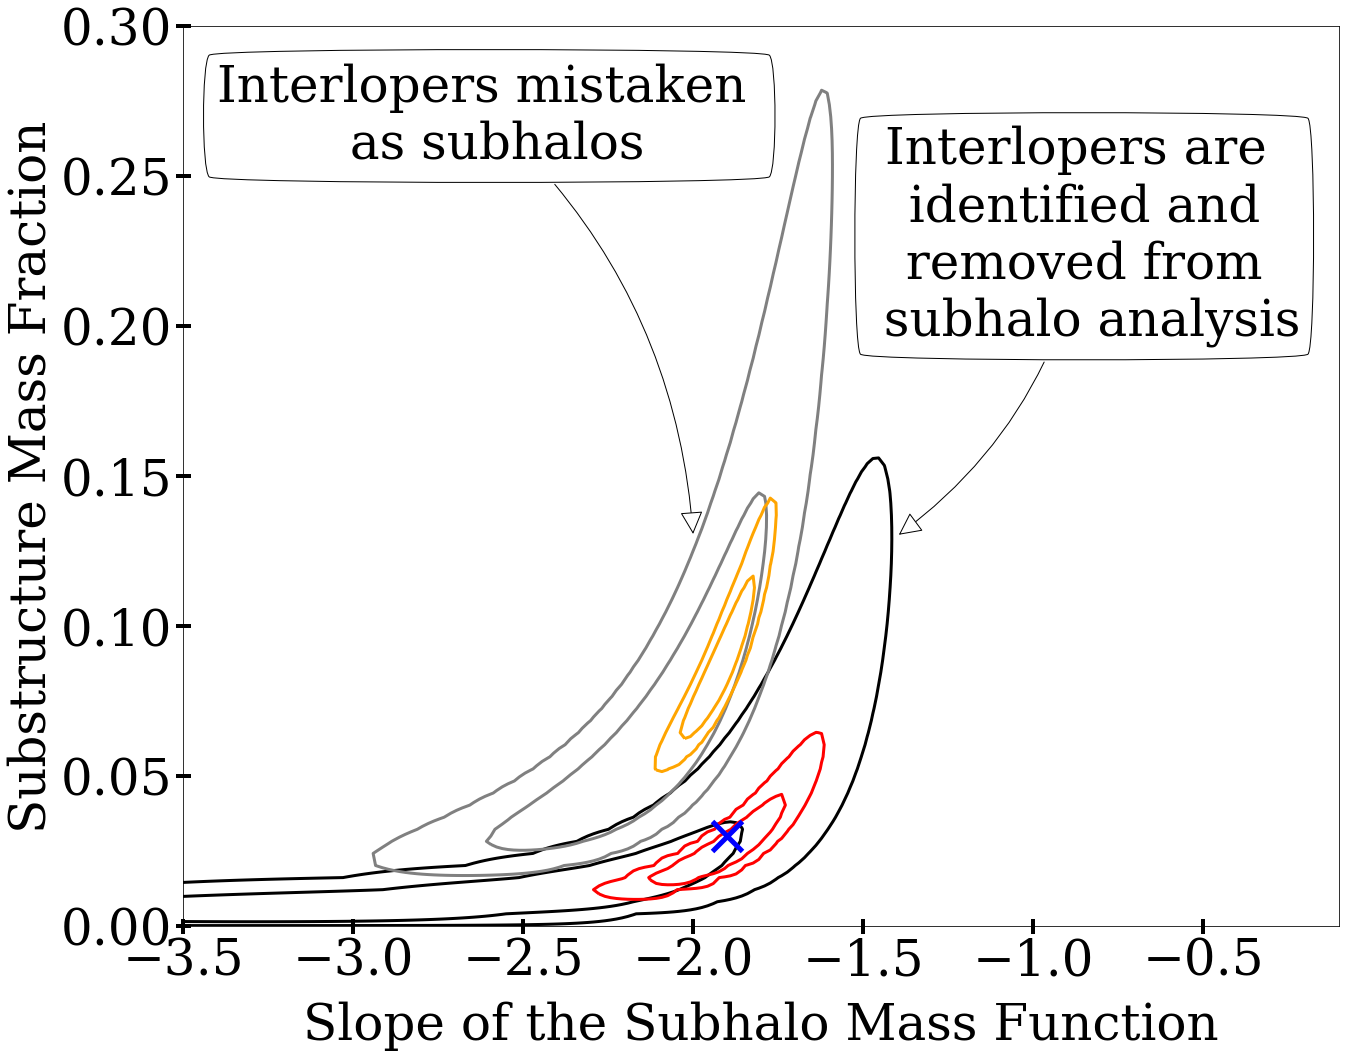

In [17]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}

matplotlib.rc('font', **font)


def sig_to_deltachi(sig,dof):
    cdf = scipy.stats.chi2.sf( sig**2,1)
    deltachi = scipy.stats.chi2.isf(cdf, dof)
    return deltachi

f, axes = plt.subplots(1, 1, figsize=(20, 16))
bounds = [sig_to_deltachi(i,2) for i in range(1,3)]

bounds = [sig_to_deltachi(i,2) for i in range(1,3)]
contours = axes.contour(avals, Avals, norprob, levels=[l2,l1], colors='black',linewidths=3.0)
contours3 = axes.contour(avals, Avals, norprob2, levels=[p2,p1], colors='grey',linewidths=3.0)

contoursb = axes.contour(avals, Avals, norprobb, levels=[l2b,l1b], colors='red',linewidths=3.0)
contoursb3 = axes.contour(avals, Avals, norprobb2, levels=[p2b,p1b], colors='orange',linewidths=3.0)
axes.set_xlim(-3.5,-0.1)
axes.set_xlabel('Slope of the Subhalo Mass Function',labelpad=15)
axes.set_ylabel('Substructure Mass Fraction')

axes.annotate("Interlopers mistaken \n as subhalos",
                  xy=(-2., 0.13), xycoords='data',
                  xytext=(-2.60, 0.27), textcoords='data',
                  size=50, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"),
                  )

axes.annotate("Interlopers are \n identified and \n removed from \n subhalo analysis",
                  xy=(-1.4, 0.13), xycoords='data',
                  xytext=(-0.85, 0.23), textcoords='data',
                  size=50, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"),
                  )

axes.plot(-1.9,0.03,'bx',markersize=30,markeredgewidth=5)
axes.set_ylim(Amin,Amax/2.)
axes.tick_params(which='major', length=15, width=4, direction='inout')



plt.tight_layout()
plt.show()

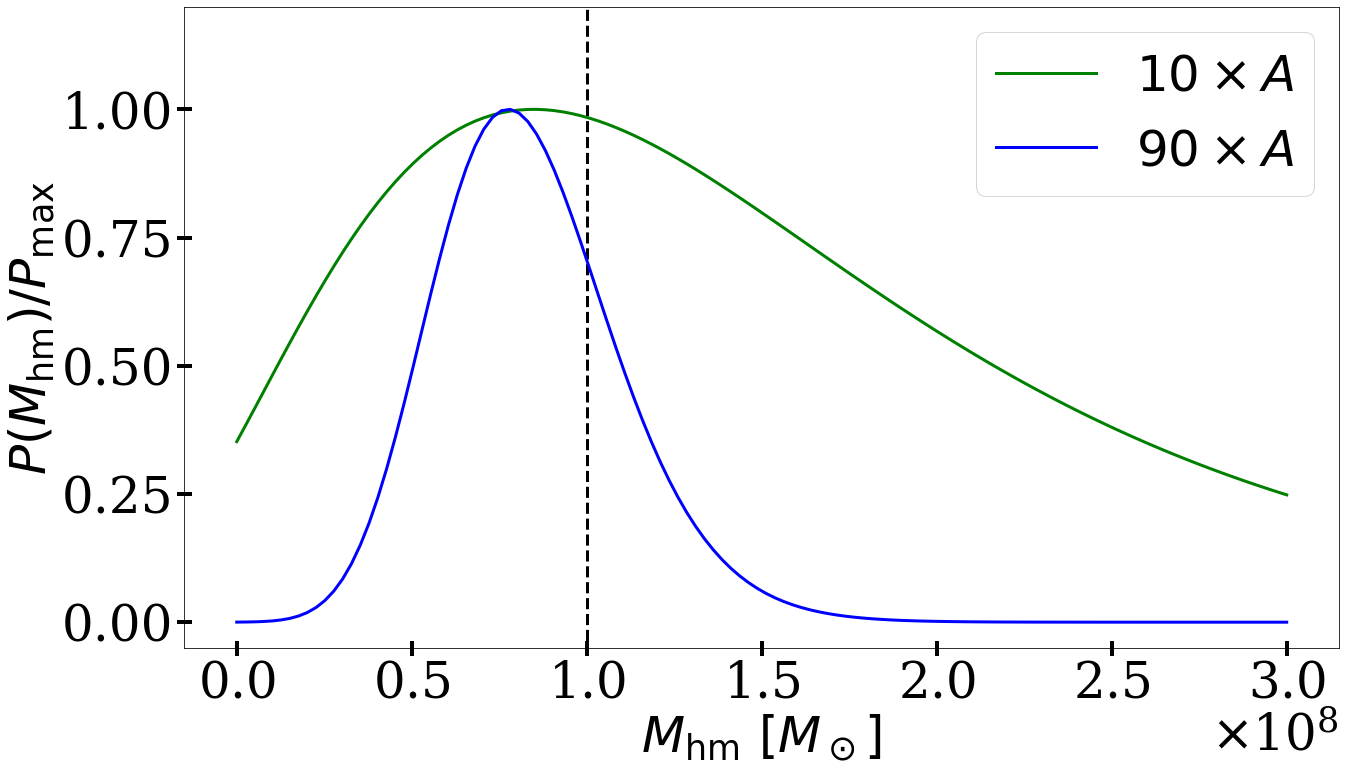

In [18]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}

matplotlib.rc('font', **font)


def sig_to_deltachi(sig,dof):
    cdf = scipy.stats.chi2.sf( sig**2,1)
    deltachi = scipy.stats.chi2.isf(cdf, dof)
    return deltachi

f, axes = plt.subplots(1, 1, figsize=(20, 12))

bounds = [sig_to_deltachi(i,2) for i in range(1,3)]
axes.plot(hmvals,norprobs/np.max(norprobs),c='green',label='$10 \\times A$',linewidth=3.0)
axes.plot(hmvals,norprobsbb/np.max(norprobsbb),c='blue',label='$90 \\times A$',linewidth=3.0)
axes.vlines(1e8,ymin=-0.5,ymax=1.5,color='black',linestyles='dashed',linewidths=3.0)

axes.set_ylabel('$P(M_\mathrm{hm})/P_\mathrm{max}$')
axes.set_xlabel('$M_\mathrm{hm}\,\, [M_\odot]$')
axes.ticklabel_format(axis="x", style="sci",useMathText=True)
axes.set_ylim(-0.05,1.2)

axes.tick_params(which='major', length=15, width=4, direction='inout')
axes.legend()

plt.tight_layout()
plt.show()

half mode mass
https://par.nsf.gov/servlets/purl/10097689